# Final Project Submission

Please fill out:
* Student name: Jeffery Rosario
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Victor Geislinger
* Blog post URL: 


In [2]:
#import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy import stats
import sklearn.preprocessing as preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import sklearn
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
%matplotlib inline

## Approach To Analysis

We will begin to look at the kings county house dataset. This dataset contains 21 columns or descriptors. The goal is to develop a model that can predict the sale price as accurately as possible of a house using a multivariate linear regression model. 

Model Quality and Approach:

-Your model should not include any predictors with p-values greater than .05.

-Your notebook shows an iterative approach to modeling, and details the parameters and results of the model at each iteration.

Level Up: Whenever necessary, you briefly explain the changes made from one iteration to the next, and why you made these choices.

You provide at least 1 paragraph explaining your final model.

You pick at least 3 coefficients from your final model and explain their impact on the price of a house in this dataset.

Questions posed:

1. What are the best predictors for the sale price of a house?
2. Are there any changes we can make to increase the sale price of a house?
3. Can location impact sale price?

In [3]:
def columns_under_x(df, n): #find columns in a DataFrame with unique values under 30
    cols = list(df.columns)
    #cols = [df[col] for col in cols if df[col].unique() < 30]
    columns = []
    for col in cols:
        if len(list(df[col].unique())) < n:
            columns.append(col)
    return columns

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

def has_basement(x):
    if x > 0:
        return 1
    else:
        return 0

In [4]:
house_data_df = pd.read_csv('kc_house_data.csv') # read kings county dataset into pandas

## Data Understanding

Let's take a look at our columns. We can see some missing values in waterfront, views, yr_renovated. Sqft_basement is an object. Might be a problem in the future.

In [5]:
house_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


## Data Preparation

We will fill in the NaN values in the waterfront column with 0 since most houses are not by the water. For yr_renovated we will instead create a column indicating whether there was a renovation done.  

In [6]:
#fill 'waterfront' and 'yr_renovated' with 0
house_data_df['waterfront'].fillna(0, inplace=True)
house_data_df['yr_renovated'].fillna(0, inplace=True)

#creat a new column name 'renovated' that captures whether the house was renovated or not
house_data_df['renovated'] = house_data_df['yr_renovated'].where(house_data_df['yr_renovated'] == 0)
house_data_df['renovated'].fillna('1', inplace = True)
house_data_df['renovated']= house_data_df['renovated'].astype(int)

#drop variables not valid for analysis
house_data_df.drop(['id','date','view'], axis = 1, inplace =True)

There are some rows with a '?' value in sqft_basement so we will convert those into the mean of the column.

In [7]:
sqft_basement_df = house_data_df.loc[house_data_df['sqft_basement'] != '?']
sqft_basement_df['sqft_basement'] = sqft_basement_df['sqft_basement'].astype(float)
sqft_basement_mean = sqft_basement_df['sqft_basement'].mean()

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
house_data_df[house_data_df['sqft_basement'] != '?']
house_data_df['sqft_basement'].replace('?', sqft_basement_mean, inplace = True)
house_data_df['sqft_basement'] = house_data_df['sqft_basement'].astype(float)

## Model #1 OLS Results

First Linear Regression model without the use of data cleaning.

In [9]:
X = house_data_df.drop(['price'], axis = 1)
y = house_data_df['price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)

train_df = pd.concat([X_train, y_train], axis = 1)

outcome = 'price'
pred_sum = '+'.join(X_train.columns)
formula = outcome+'~'+ pred_sum
model = ols(formula = formula, data = train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     1843.
Date:                Fri, 05 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:13:30   Log-Likelihood:            -1.9742e+05
No. Observations:               14469   AIC:                         3.949e+05
Df Residuals:                   14450   BIC:                         3.950e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.011e+05   3.61e+06     -0.056      0.956   -7.27e+06    6.87e+06
bedrooms      -4.069e+04   2428.709    -16.754      0.000   -4.55e+04   -3.59e+04
bathrooms      4.557e+04   4074.479     11.185      0.000    3.76e+04    5.36e+04
sqft_living      89.2993     26.579      3.360      0.001      37.201     141.397
sqft_lot          0.1068      0.059      1.811      0.070      -0.009       0.222
floors         1.326e+04   4464.500      2.970      0.003    4510.575     2.2e+04
waterfront     8.058e+05   2.07e+04     38.836      0.000    7.65e+05    8.47e+05
condition      2.954e+04   2906.488     10.164      0.000    2.38e+04    3.52e+04
grade          1.042e+05   2665.785     39.072      0.000    9.89e+04    1.09e+05
sqft_above       80.1024     26.554      3.017      0.003      28.053     132.152
sqft_basement    78.6563     26.544      2.963      0.003      26.626     130.687
yr_built      -2860.6337     88.787    -32.219      0.000   -3034.668   -2686.600
yr_renovated   3244.4179    602.485      5.385      0.000    2063.470    4425.366
zipcode        -501.2112     40.694    -12.317      0.000    -580.976    -421.446
lat             5.56e+05   1.33e+04     41.811      0.000     5.3e+05    5.82e+05
long          -2.273e+05   1.62e+04    -13.999      0.000   -2.59e+05   -1.95e+05
sqft_living15    41.9228      4.237      9.895      0.000      33.618      50.227
sqft_lot15       -0.3857      0.089     -4.335      0.000      -0.560      -0.211
renovated     -6.429e+06    1.2e+06     -5.346      0.000   -8.79e+06   -4.07e+06
==============================================================================
Omnibus:                    11823.168   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           917983.767
Skew:                           3.420   Prob(JB):                         0.00
Kurtosis:                      41.417   Cond. No.                     2.14e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
linreg1 = LinearRegression()
linreg1.fit(X_train, y_train)
y_pred_train = linreg1.predict(X_train)
y_pred_test = linreg1.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
r2_score(y_train, y_pred_train)
print(train_mse)
print(test_mse)


41570068380.20649
41683718891.198586


## Evaluation

Without any data transformations, we get an adjusted R-squared value of 0.697. The mean squared error is relatively close to eachother. However these estimations for the sale price are off. 

## Model 2

Let's seperate the categorical variables from the continuous variables. We will create a dataframe with columns that have at last 30 unique items. Let's also take a look at the distributions of the continuous variables.

In [11]:
categorical_df = X_train.loc[:,columns_under_x(house_data_df,30)]
categorical_df['zipcode'] = X_train['zipcode']
continuous_df = house_data_df.drop(columns_under_x(house_data_df,30), axis = 1)
continuous_df.drop(['zipcode'], axis = 1,inplace = True)

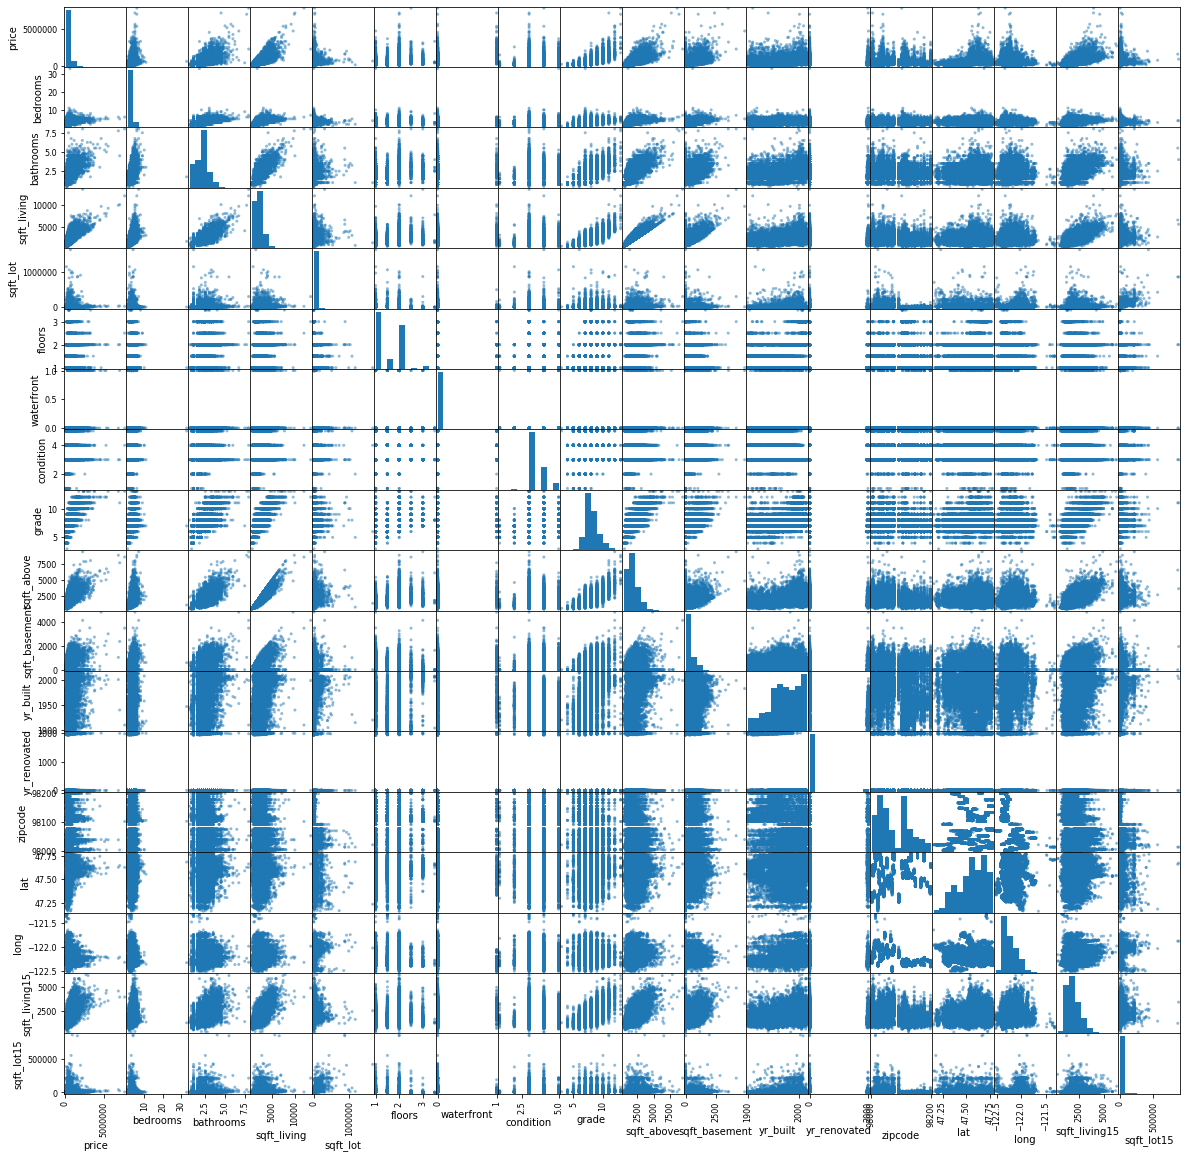

In [14]:
pd.plotting.scatter_matrix(house_data_df, figsize = (20,20));

## Data Preparation

To properly encorporate categorical variables in our model, let's use one hot encoding. 

In [12]:
#get categorical and continuous variables
categorical_df = house_data_df.loc[:,columns_under_x(house_data_df,30)]
categorical_df['zipcode'] = house_data_df['zipcode']
continuous_df = house_data_df.drop(columns_under_x(house_data_df,30), axis = 1)
continuous_df.drop(['zipcode'], axis = 1,inplace = True)

#get dummies for the categorical data
bdrms = pd.get_dummies(categorical_df['bedrooms'], prefix = 'bdrms', drop_first=True)
bthrms = pd.get_dummies(categorical_df['bathrooms'], prefix = 'bthrms', drop_first=True)
cond = pd.get_dummies(categorical_df['condition'], prefix = 'cond', drop_first=True)
floors = pd.get_dummies(categorical_df['floors'], prefix = 'floors', drop_first=True)
zipcode = pd.get_dummies(house_data_df['zipcode'], prefix = 'zipcode', drop_first=True)
renovated = pd.get_dummies(house_data_df['renovated'], prefix = 'renovated', drop_first=True)
categorical_df['waterfront']= categorical_df['waterfront'].astype(int)
wtrfront = pd.get_dummies(categorical_df['waterfront'], prefix = 'waterfront', drop_first=True)

br_list = list(bthrms.columns)
br_without_period = [col.replace('.','_') for col in br_list]
bthrms.columns = br_without_period
flr_list = list(floors.columns)
flr_without_period = [col.replace('.','_') for col in flr_list]
floors.columns = flr_without_period
combined_df = pd.concat([bdrms, cond,floors,continuous_df, bthrms, wtrfront, zipcode, renovated], axis = 1)

## Model 2 OLS Results

In [13]:
X = combined_df.drop('price', axis = 1)
y = combined_df.loc[:,'price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .33, random_state = 40)

outcome = 'price'
pred_sum = '+'.join(X_train.columns)
formula = outcome+'~'+ pred_sum
model = ols(formula = formula, data = pd.concat([X_train, y_train], axis =1 )).fit()

linear = LinearRegression()
linear.fit(X_train, y_train)

y_pred_test = linear.predict(X_test)
y_pred_train = linear.predict(X_train)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
model.summary()
#print(train_mse)
#print(test_mse)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     473.0
Date:                Fri, 05 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:13:43   Log-Likelihood:            -1.9408e+05
No. Observations:               14469   AIC:                         3.884e+05
Df Residuals:                   14341   BIC:                         3.894e+05
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.843e+07   7.49e+06     -3.797      0.000   -4.31e+07   -1.38e+07
bdrms_2       -1.726e+04   1.51e+04     -1.141      0.254   -4.69e+04    1.24e+04
bdrms_3       -2.572e+04   1.51e+04     -1.708      0.088   -5.52e+04    3797.247
bdrms_4       -5.513e+04   1.54e+04     -3.579      0.000   -8.53e+04   -2.49e+04
bdrms_5       -8.838e+04   1.62e+04     -5.450      0.000    -1.2e+05   -5.66e+04
bdrms_6       -1.457e+05   1.99e+04     -7.305      0.000   -1.85e+05   -1.07e+05
bdrms_7       -3.235e+05    3.6e+04     -8.976      0.000   -3.94e+05   -2.53e+05
bdrms_8       -2.296e+05   5.55e+04     -4.141      0.000   -3.38e+05   -1.21e+05
bdrms_9       -3.236e+05   9.64e+04     -3.358      0.001   -5.13e+05   -1.35e+05
bdrms_10       -4.07e+05   9.75e+04     -4.175      0.000   -5.98e+05   -2.16e+05
bdrms_11         -0.0356      0.009     -3.789      0.000      -0.054      -0.017
bdrms_33          0.0042      0.001      3.888      0.000       0.002       0.006
cond_2          1.04e+05   3.97e+04      2.618      0.009    2.61e+04    1.82e+05
cond_3         1.184e+05   3.67e+04      3.226      0.001    4.65e+04     1.9e+05
cond_4         1.435e+05   3.67e+04      3.908      0.000    7.15e+04    2.15e+05
cond_5         1.924e+05    3.7e+04      5.203      0.000     1.2e+05    2.65e+05
floors_1_5    -1.446e+04   5530.773     -2.614      0.009   -2.53e+04   -3618.688
floors_2_0    -2.651e+04   4837.100     -5.480      0.000    -3.6e+04    -1.7e+04
floors_2_5     6.875e+04   1.62e+04      4.235      0.000    3.69e+04    1.01e+05
floors_3_0    -5.546e+04   1.02e+04     -5.451      0.000   -7.54e+04   -3.55e+04
floors_3_5     2.079e+05   8.29e+04      2.510      0.012    4.55e+04     3.7e+05
sqft_living     102.1410     21.293      4.797      0.000      60.404     143.878
sqft_lot          0.2994      0.047      6.303      0.000       0.206       0.392
sqft_above      117.1896     21.386      5.480      0.000      75.270     159.109
sqft_basement    54.0156     21.313      2.534      0.011      12.239      95.792
yr_built         48.9729     84.649      0.579      0.563    -116.951     214.897
yr_renovated   3192.9153    472.086      6.763      0.000    2267.566    4118.264
lat            2.236e+05   7.88e+04      2.837      0.005    6.91e+04    3.78e+05
long          -1.422e+05   5.52e+04     -2.576      0.010    -2.5e+05    -3.4e+04
sqft_living15    69.0629      3.473     19.887      0.000      62.256      75.870
sqft_lot15       -0.2046      0.077     -2.650      0.008      -0.356      -0.053
bthrms_0_75    9.306e+04   9.68e+04      0.961      0.336   -9.67e+04    2.83e+05
bthrms_1_0     5.694e+04   9.42e+04      0.605      0.545   -1.28e+05    2.42e+05
bthrms_1_25    4.665e+04    1.1e+05      0.422      0.673    -1.7e+05    2.63e+05
bthrms_1_5     3.654e+04   9.43e+04      0.387   

## Evaluation

We have a great improvement of our model. We went from a 0.697 R-sqaured value to a 0.808 adjusted R-sqaured value.

We can do better. Let's look at the continuous variables.

## Data Understanding

We take a look at the continuous variables to understand their distributions. Latitude and longitude are coordinates. They will need to be transformed in another way. All other columns have a high positive skew. We will do log transformations to make the distributions more normal.

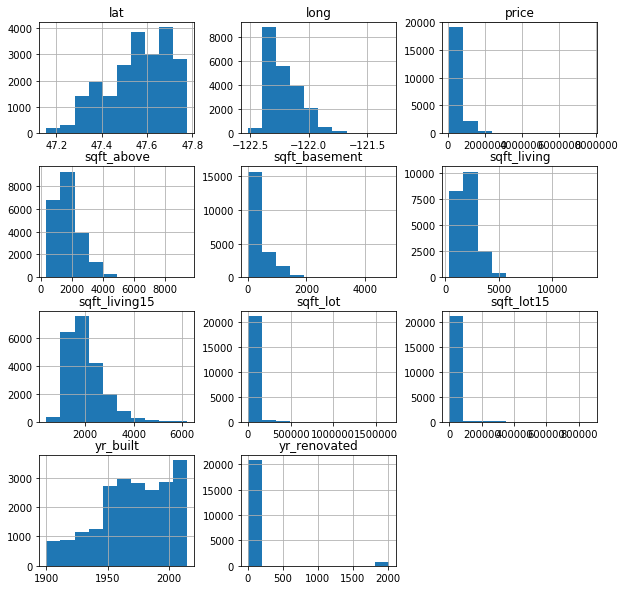

In [248]:
pd.plotting.hist_frame(continuous_df, figsize = (10,10));

## Model #3 

Let's transform our data. We will perform log transformations for the skewed data. 

In [14]:
df = combined_df.copy()

#provide an interaction since latitude and longitude are related
df['lat_long']= df['lat'] * df['long']

#log transformations for skewed data
df['sqft_living'] = np.log(df['sqft_living'])
df['sqft_lot'] = np.log(df['sqft_lot'])
df['sqft_above'] = np.log(df['sqft_above'])
df['price']= np.log(df['price'])

#df['sqft_basement'] = df['sqft_basement']

#df.drop(['zipcode', 'lat', 'long', 'yr_built'], axis = 1, inplace = True)

df['basement'] = df['sqft_basement'].where(df['sqft_basement'] == 0)
df['basement'].fillna('1', inplace = True)
df['basement'] = pd.get_dummies(df['basement'], prefix = 'basement',drop_first=True)

scaled_df = df
X = scaled_df.drop('price', axis = 1)
y = scaled_df['price']

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = .33, random_state = 40)

lin = LinearRegression()
cv2_5_results = np.mean(cross_val_score(lin, x_train, y_train, cv = 5, scoring = 'r2'))
cv2_10_results = np.mean(cross_val_score(lin, x_train, y_train, cv = 10))


outcome = 'price'
pred_sum = '+'.join(x_train.columns)
pred_sum.replace('.','_')
formula = outcome+'~'+ pred_sum
model = ols(formula = formula, data = scaled_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1093.
Date:                Fri, 05 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:13:49   Log-Likelihood:                 5209.1
No. Observations:               21597   AIC:                        -1.015e+04
Df Residuals:                   21465   BIC:                            -9101.
Df Model:                         131                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2381.1352   1604.936     -1.484      0.138   -5526.929     764.659
bdrms_2          -0.0256      0.015     -1.750      0.080      -0.054       0.003
bdrms_3          -0.0638      0.015     -4.333      0.000      -0.093      -0.035
bdrms_4          -0.0814      0.015     -5.371      0.000      -0.111      -0.052
bdrms_5          -0.1238      0.016     -7.771      0.000      -0.155      -0.093
bdrms_6          -0.1761      0.019     -9.103      0.000      -0.214      -0.138
bdrms_7          -0.3045      0.035     -8.610      0.000      -0.374      -0.235
bdrms_8          -0.2726      0.056     -4.861      0.000      -0.383      -0.163
bdrms_9          -0.3298      0.088     -3.756      0.000      -0.502      -0.158
bdrms_10         -0.3990      0.113     -3.535      0.000      -0.620      -0.178
bdrms_11         -0.0909      0.192     -0.474      0.636      -0.467       0.285
bdrms_33          0.0110      0.192      0.058      0.954      -0.364       0.386
cond_2            0.1857      0.038      4.827      0.000       0.110       0.261
cond_3            0.3360      0.036      9.405      0.000       0.266       0.406
cond_4            0.3793      0.036     10.613      0.000       0.309       0.449
cond_5            0.4477      0.036     12.447      0.000       0.377       0.518
floors_1_5        0.0003      0.005      0.058      0.953      -0.010       0.011
floors_2_0       -0.0075      0.005     -1.568      0.117      -0.017       0.002
floors_2_5        0.0400      0.016      2.485      0.013       0.008       0.072
floors_3_0       -0.0474      0.010     -4.620      0.000      -0.067      -0.027
floors_3_5       -0.0032      0.073     -0.043      0.965      -0.146       0.140
sqft_living       0.2510      0.020     12.792      0.000       0.213       0.289
sqft_lot          0.0724      0.003     26.402      0.000       0.067       0.078
sqft_above        0.3003      0.018     16.557      0.000       0.265       0.336
sqft_basement  3.354e-05   8.76e-06      3.830      0.000    1.64e-05    5.07e-05
yr_built          0.0007   8.28e-05      7.947      0.000       0.000       0.001
yr_renovated      0.0041      0.000      9.144      0.000       0.003       0.005
lat              48.8016     33.723      1.447      0.148     -17.298     114.901
long            -19.3254     13.137     -1.471      0.141     -45.074       6.424
sqft_living15     0.0001   3.26e-06     39.938      0.000       0.000       0.000
sqft_lot15    -1.594e-07   6.76e-08     -2.357      0.018   -2.92e-07   -2.68e-08
bthrms_0_75       0.2018      0.098      2.055      0.040       0.009       0.394
bthrms_1_0        0.1839      0.096      1.923      0.054      -0.003       0.371
bthrms_1_25       0.2171      0.115      1.890      0.059      -0.008       0.442
bthrms_1_5        0.1827      0.096      1.908   

In [257]:
print(cv2_5_results)
print(cv2_10_results)

0.8616637303394278
0.8653284127672493


How else can we improve the model? Let's use stepwise feature selection. We will only keep the features that have a p-value above 0.05. We will also use K-means cluster to group our data. 

In [18]:
step = stepwise_selection(scaled_x, y_train)

C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp i

C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp i

C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Public\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp i

Add  lat                            with p-value 0.0
Add  floors_2_0                     with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Add  sqft_living                    with p-value 0.0
Drop floors_2_0                     with p-value 0.510215


C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  c2                             with p-value 0.0
Add  waterfront_1                   with p-value 1.37004e-134
Add  zipcode_98004                  with p-value 2.33565e-132
Add  zipcode_98155                  with p-value 3.93708e-90
Add  zipcode_98028                  with p-value 3.27076e-90
Add  zipcode_98133                  with p-value 1.35774e-89
Add  zipcode_98022                  with p-value 7.70974e-84
Add  zipcode_98011                  with p-value 7.2514e-76
Add  zipcode_98034                  with p-value 3.14581e-86
Add  zipcode_98125                  with p-value 4.71178e-79
Add  zipcode_98168                  with p-value 1.48444e-78
Add  zipcode_98045                  with p-value 3.14132e-79
Add  zipcode_98178                  with p-value 5.90545e-71
Add  zipcode_98072                  with p-value 1.86603e-66
Add  sqft_above                     with p-value 2.17084e-64
Add  zipcode_98040                  with p-value 1.43017e-62
Add  zipcode_98019             

## Model #4 

In [17]:
df = combined_df.copy()

df['lat_long']= df['lat'] * df['long']
df['sqft_lot'] = np.log(df['sqft_lot'])
df['sqft_lot15'] = np.log(df['sqft_lot15'])
df['sqft_above'] = np.log(df['sqft_above'])
df['sqft_basement'] = np.log(1+ df['sqft_basement'])
df['price']= np.log(df['price'])
df['sqft_living'] = np.log(df['sqft_living'])
df['sqft_living15'] = np.log(df['sqft_living15'])

# Add one-hot encoding for sqft_basement

df['basement'] = df['sqft_basement'].where(df['sqft_basement'] == 0)
df['basement'].fillna('1', inplace = True)
df['basement'] = pd.get_dummies(df['basement'], prefix = 'basement',drop_first=True)

#Let's split our training and test dataset
X = df.drop(['price', 'yr_built', 'yr_renovated'], axis = 1)
y = df['price']

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = .33, random_state = 40)

y_train.reset_index(drop = True, inplace = True)
categorical_df = x_train.loc[:,columns_under_x(x_train,30)]
continuous_df = x_train.drop(columns_under_x(x_train,30), axis = 1)
categorical_df.reset_index(drop = True, inplace = True)

#Add clusters depending on location(lat,long)
kmeans = KMeans(n_clusters=2)
k = pd.concat([continuous_df['lat'], continuous_df['long']], axis = 1)
k = kmeans.fit_transform(k)
lat_long_df = pd.DataFrame(k, columns = ['c1', 'c2'])   


#Preprocessing continuous variables using MinMaxScaler
scaler = preprocessing.MinMaxScaler()
scaled_x = scaler.fit_transform(continuous_df)
scaled_x = pd.DataFrame(scaled_x, columns = continuous_df.columns)
scaled_x = pd.concat([scaled_x, categorical_df, lat_long_df], axis = 1)
#scaled_x = scaled_x[step]
scaled_df = pd.concat([scaled_x, y_train], axis = 1)

#Cross validation R-squared on training set
lin = LinearRegression()
lin.fit(scaled_x, y_train)
cv_10_results = np.mean(cross_val_score(lin, scaled_x, y_train, cv = 10, scoring = 'r2'))

y_pred_train = lin.predict(scaled_x)
#y_pred_test = lin.predict(x_test)

test_mse = mean_squared_error(y_test, y_pred_test)
train_mse = mean_squared_error(y_train, y_pred_train)

outcome = 'price'
pred_sum = '+'.join(scaled_x.columns)
pred_sum.replace('.','_')
formula = outcome+'~'+ pred_sum
model = ols(formula = formula, data = scaled_df).fit()
model.summary()
#print(cv_10_results)
#print()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     752.8
Date:                Fri, 05 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:14:08   Log-Likelihood:                 3589.5
No. Observations:               14469   AIC:                            -6919.
Df Residuals:                   14339   BIC:                            -5934.
Df Model:                         129                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -50.4827     23.396     -2.158      0.031     -96.342      -4.624
sqft_living       0.9052      0.092      9.857      0.000       0.725       1.085
sqft_lot          0.6322      0.038     16.756      0.000       0.558       0.706
sqft_above        1.0331      0.076     13.530      0.000       0.883       1.183
sqft_basement     0.1904      0.060      3.156      0.002       0.072       0.309
lat              66.3186     25.503      2.600      0.009      16.330     116.307
long            -48.6826     19.228     -2.532      0.011     -86.373     -10.992
sqft_living15     0.6726      0.023     28.961      0.000       0.627       0.718
sqft_lot15       -0.0824      0.035     -2.359      0.018      -0.151      -0.014
lat_long         97.9796     37.263      2.629      0.009      24.939     171.020
bdrms_2          -0.0254      0.018     -1.429      0.153      -0.060       0.009
bdrms_3          -0.0657      0.018     -3.688      0.000      -0.101      -0.031
bdrms_4          -0.0835      0.018     -4.551      0.000      -0.119      -0.048
bdrms_5          -0.1220      0.019     -6.324      0.000      -0.160      -0.084
bdrms_6          -0.1899      0.024     -8.050      0.000      -0.236      -0.144
bdrms_7          -0.2717      0.042     -6.431      0.000      -0.354      -0.189
bdrms_8          -0.3263      0.065     -5.036      0.000      -0.453      -0.199
bdrms_9          -0.3485      0.112     -3.100      0.002      -0.569      -0.128
bdrms_10         -0.3785      0.114     -3.325      0.001      -0.602      -0.155
bdrms_11      -4.844e-11   1.92e-11     -2.523      0.012   -8.61e-11   -1.08e-11
bdrms_33       3.008e-11   1.19e-11      2.524      0.012    6.72e-12    5.34e-11
cond_2            0.1975      0.046      4.261      0.000       0.107       0.288
cond_3            0.3801      0.043      8.868      0.000       0.296       0.464
cond_4            0.4141      0.043      9.650      0.000       0.330       0.498
cond_5            0.4803      0.043     11.119      0.000       0.396       0.565
floors_1_5       -0.0234      0.006     -3.632      0.000      -0.036      -0.011
floors_2_0       -0.0005      0.006     -0.089      0.929      -0.012       0.011
floors_2_5        0.0142      0.019      0.744      0.457      -0.023       0.052
floors_3_0       -0.0251      0.012     -2.142      0.032      -0.048      -0.002
floors_3_5        0.0607      0.097      0.627      0.530      -0.129       0.250
bthrms_0_75       0.3137      0.113      2.775      0.006       0.092       0.535
bthrms_1_0        0.2301      0.110      2.092      0.036       0.015       0.446
bthrms_1_25       0.3532      0.129      2.742      0.006       0.101       0.606
bthrms_1_5        0.2303      0.110      2.091      0.037       0.014       0.446
bthrms_1_75       0.2524      0.110      2.292   

Great. Now let's do this with the test set. We will apply the same preprocessing steps for the test set as we did with the training set.

In [547]:
y_test.reset_index(drop = True, inplace = True)
test_categorical_df = x_test.loc[:,columns_under_x(x_test,30)]
test_continuous_df = x_test.drop(columns_under_x(x_test,30), axis = 1)
test_categorical_df.reset_index(drop = True, inplace = True)

kmeans = KMeans(n_clusters=2)
k = pd.concat([test_continuous_df['lat'], test_continuous_df['long']], axis = 1)
k = kmeans.fit_transform(k)
test_lat_long_df = pd.DataFrame(k, columns = ['c1', 'c2'])  

scaler = preprocessing.MinMaxScaler()
test_scaled_x = scaler.fit_transform(test_continuous_df)
test_scaled_x = pd.DataFrame(test_scaled_x, columns = test_continuous_df.columns)
test_scaled_x = pd.concat([test_scaled_x, test_categorical_df, test_lat_long_df], axis = 1)
test_scaled_x = scaled_x[step]
test_scaled_df = pd.concat([test_scaled_x, y_test], axis = 1)

cv10_test_results = np.mean(cross_val_score(lin, scaled_x, y_test, cv = 10, scoring = 'r2' ))
cv10_test_results

0.8683016795432256

Some graphical presentations of linear regression of predicted values.

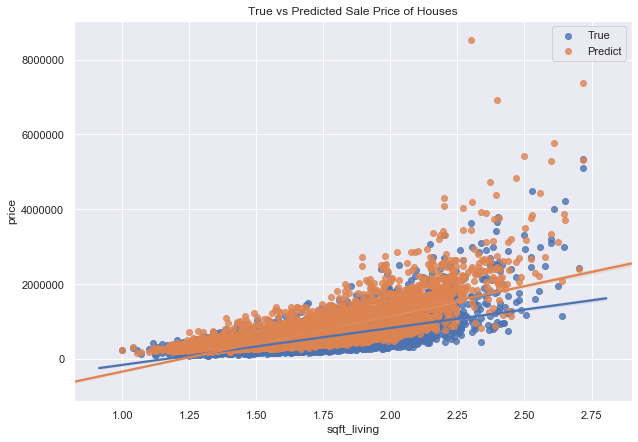

In [560]:
x_living = np.exp(test_scaled_x['sqft_living'])
y_price = np.exp(y_test)
y_pred_price = np.exp(y_pred_test)

plt.figure(figsize = (10,7))
sns.regplot(x_living, y_price,label = 'True')
sns.regplot(x_living, y_pred_price, label = 'Predict')
plt.title("True vs Predicted Sale Price of Houses")
plt.legend();

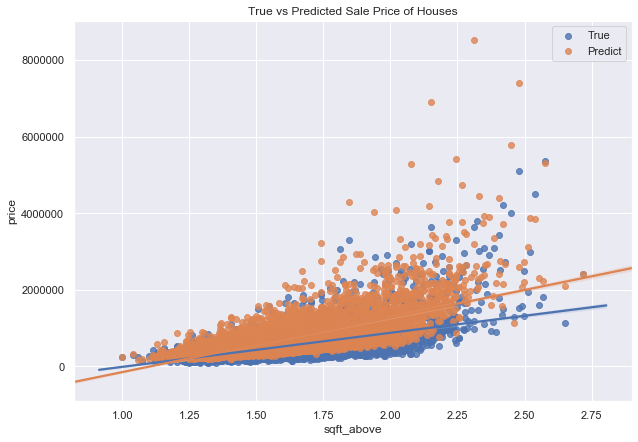

In [562]:
x_above = np.exp(test_scaled_x['sqft_above'])
plt.figure(figsize=(10,7))
sns.regplot(x_above, y_price,label = 'True')
sns.regplot(x_above, y_pred_price, label = 'Predict')
plt.legend()
plt.title("True vs Predicted Sale Price of Houses");

In [657]:
top_20 = model.params.sort_values(ascending = False).head(20)
top_20 = pd.DataFrame({'Predictors':top_20.index, 'Coefficient':top_20.values})

In [658]:
top_20.set_index('Predictors', inplace = True)
top_20.drop('Intercept', inplace =True)
top_20.reset_index(inplace = True)

In [659]:
top_20

,Predictors,Coefficient
0,lat_long,4.555778
1,lat,2.699121
2,c2,1.636482
3,sqft_living,1.048355
4,sqft_above,0.931554
5,waterfront_1,0.707795
6,bthrms_7_75,0.697017
7,sqft_living15,0.671017
8,bthrms_6_5,0.666972
9,bthrms_6_25,0.610188


## Conclusion

The final model has an adjusted R-squared value of 0.870. This is a significant improvement from our first adjusted R-squared value of 0.697. With adjustments to the categorical variables and the continuous variables we can more accurately predict our dependent variable 'price'.

For the continuous variables, we apply log transformations to the positively skewed data for them to appear more normal. A MinMax Scaler was also applied to reduc th effect of outliers and reduce the values to be between 0-1. To handle categorical variables we used one hot encoding. 

Two columns required different treatments. The latitude and longitude columns provided two distinct clusters using Kmeans clustering.

The three most important predictors are the square footage above, the square footage of the basement, and the Kmeans clusters which translates to LOCATION.

Let's revisit the questions posed in the beginning of our analysis:

1. What are the best predictors for the sale price of a house?
Location, amount of bathrooms or bedrooms, square footage above ground, square footage of the basement, condition of the house

2. Are there any changes we can make to increase the sale price of a house?
We can increase the amount of bathrooms or bedrooms of the property. We can renovate the property or help improve the condition of the house.
3. Can location impact sale price?
Yes. Some locations may negatively impact the sale price of a house. It may not be worth it to buy a house in a location that is negatively impacted by it's location if the the ROI is not substantial.

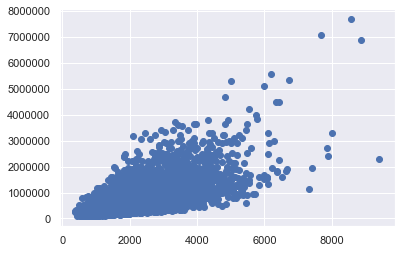

In [589]:
plt.scatter(x = np.exp(df['sqft_above']), y = np.exp(df['price']))